{ФКИИ} Курсовая работа (Исследование датасета)

UTKFaces — датасет изображений лиц, размеченных по возрасту, полу и этнической принадлежности. Его используют для задач классификации, регрессии (предсказание возраста) и анализа изображений.Датасет содержит более 20 000 изображений, охватывающих широкий диапазон возрастов (0–116 лет).

Каждое изображение в формате JPG, название файла имеет структуру: <age>_<gender>_<race>_<date_time>.jpg.
Например, 25_1_2_20170109150553012.jpg означает:
- Возраст: 25;
- Пол: 1 (мужской), 0 (женский);
- Раса: 2 (азиатская);
- Дата создания: 2017-01-09 15:05:53.

In [1]:
# Для корректной работы PyTorch даталоадера
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from collections import Counter

[Даталоадер](https://pyimagesearch.com/2022/08/17/multi-task-learning-and-hydranets-with-pytorch/#download-the-code)

In [3]:
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        try:
            age, gender, race, _ = img_name.split('_')
            age = int(age)
            gender = int(gender)
            race = int(race)
        except ValueError:
            raise ValueError(f"Некорректный формат имени файла: {img_name}")
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, {'age': age, 'gender': gender, 'race': race}

def get_dataloader(root_dir, batch_size, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((128, 128)), 
        transforms.ToTensor(),
    ])

    dataset = UTKFaceDataset(root_dir=root_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [4]:
def show_images_with_labels(images, labels, batch_size):
    rows = int(batch_size ** 0.5)
    cols = (batch_size + rows - 1) // rows
    fig, axes = plt.subplots(
        rows, cols, figsize=(12, 14), 
        gridspec_kw={'wspace': 0.4, 'hspace': 0.6}
    )
    axes = axes.flatten()

    for i in range(batch_size):
        img = images[i]
        img = img.permute(1, 2, 0).numpy()

        age = labels['age'][i].item()
        gender = 'Female' if labels['gender'][i].item() == 1 else 'Male'
        race_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
        race = race_dict.get(labels['race'][i].item(), "Unknown")

        axes[i].imshow(img)
        axes[i].set_title(f"Age: {age}\nGender: {gender}\nRace: {race}", fontsize=10)
        axes[i].axis('off')

    for j in range(batch_size, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


C:\Users\Alex\AppData\Local\Temp\ipykernel_11084\2710359337.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


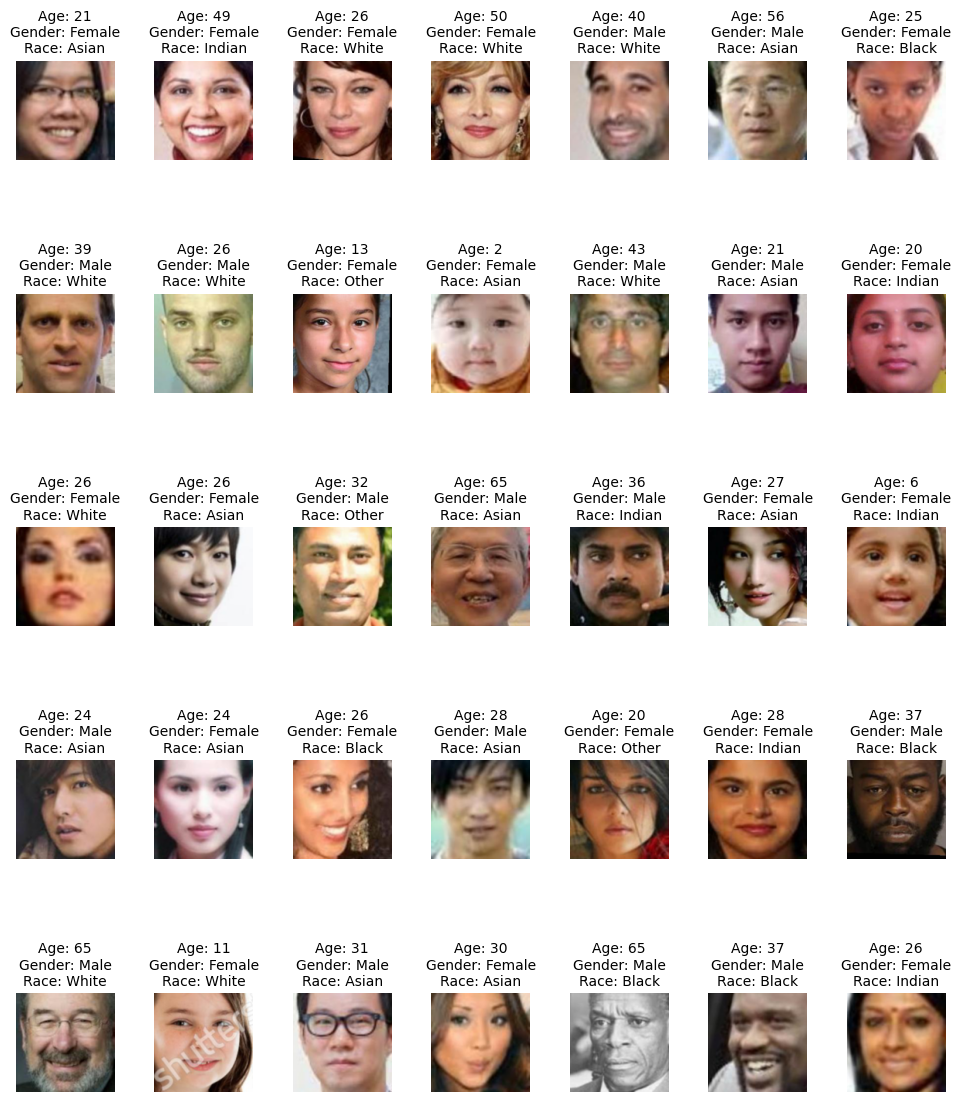

In [5]:
root_dir = "utk-face_cropped"
batch_size=35
dataloader = get_dataloader(root_dir, batch_size)

for images, labels in dataloader:
    show_images_with_labels(images, labels, batch_size)
    break

In [6]:
ages = []
genders = []
races = []

root_dir = 'utk-face_cropped/'
for i in os.listdir(root_dir):
    split = i.split('_')
    
    if len(split) < 4:
        continue

    try:
        age = int(split[0])
        gender = int(split[1])
        race = int(split[2])

        ages.append(age)
        genders.append(gender)
        races.append(race)
    except ValueError:
        print(f"Ошибка в данных файла: {i}")
        continue

Статистика

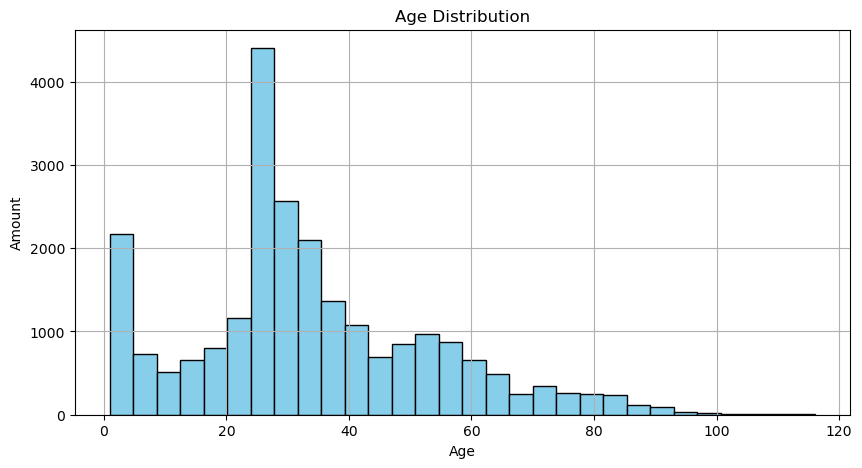

In [7]:
plt.figure(figsize=(10, 5))
plt.hist(ages, bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

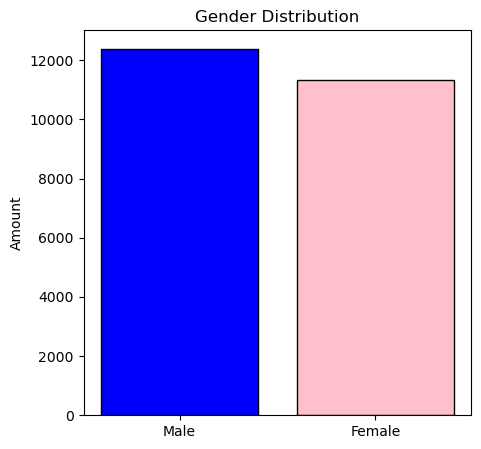

In [8]:
gender_counts = Counter(genders)
plt.figure(figsize=(5, 5))
plt.bar(['Male', 'Female'], [gender_counts[0], gender_counts[1]], color=['blue', 'pink'], edgecolor='black')
plt.title('Gender Distribution')
plt.ylabel('Amount')
plt.show()

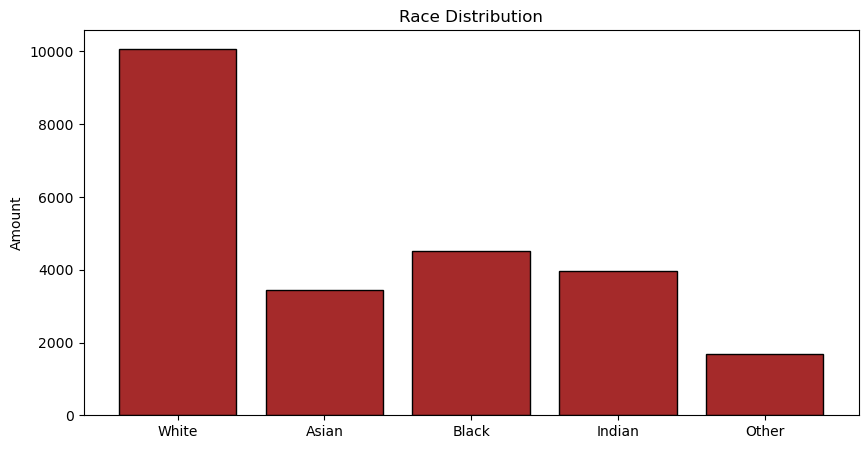

In [9]:
race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
race_counts = Counter(races)
plt.figure(figsize=(10, 5))
plt.bar([race_labels[k] for k in race_counts.keys()], race_counts.values(), color='brown', edgecolor='black')
plt.title('Race Distribution')
plt.ylabel('Amount')
plt.show()

В качестве задачи, которую можно решаить с применением данного UTKFaces, будем рассматривать задачу классификации данных по изображению.

Статья ["MiVOLO: Multi-input Transformer for Age and Gender Estimation"](https://arxiv.org/pdf/2307.04616v2) представляет подход к оценке возраста и пола, основанный на современных трансформерных архитектурах. Авторы предлагают модель [MiVOLO (MiVOLO (Multi-input Vision OutLOoker)](https://github.com/WildChlamydia/MiVOLO), которая объединяет информацию как с лица, так и с изображения всего человека, что повышает точность предсказаний, особенно в случаях, когда лицо частично или полностью скрыто. 

В рамках исследования авторы использовали несколько популярных наборов данных:
- UTKFace;
- Adience;
- IMDB-WIKI;
- MORPH;
- FG-NET.

Модель MiVOLO была обучена на датасете UTKFaces для извлечения признаков лица, которые затем комбинировались с признаками всего тела для улучшения общей производительности модели.

Обучение нейронной сети происходило на UTKFace, с использованием оптимизатора AdamW с $\text{learning rate}=1.5e-5$ и $\text{weight decay} = 5e-5$. Обучение модели проводилось в течение 220 эпох на каждом из датасетов.


Метрики для UTKFace:
- Age MAE (средняя абсолютная ошибка возраста);
- Age CS@5 (процент предсказаний возраста с отклонением ≤ 5 лет);
- Gender Accuracy (точность классификации пола).

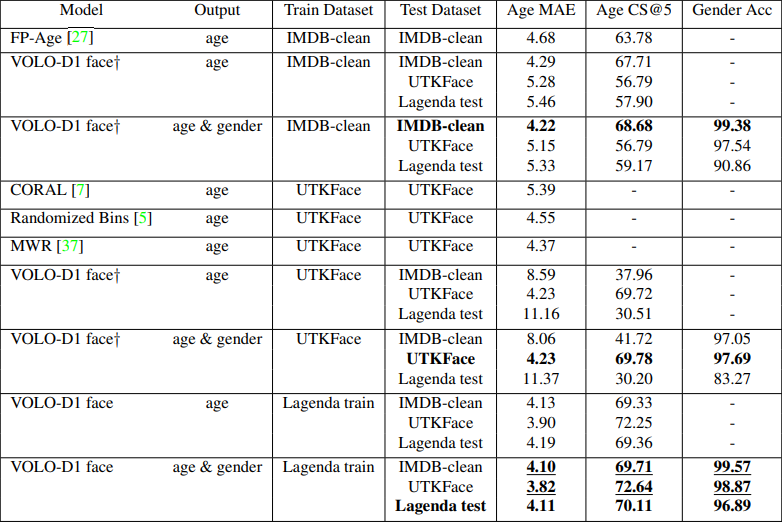

Модель VOLO-D1, обученная на данных лица и тела (age & gender), демонстрирует наилучшую производительность на UTKFace.

Кроме того, в статье датасет UTKFace использовался как для обучения, так и для тестирования модели VOLO-D1/MiVOLO-D1:

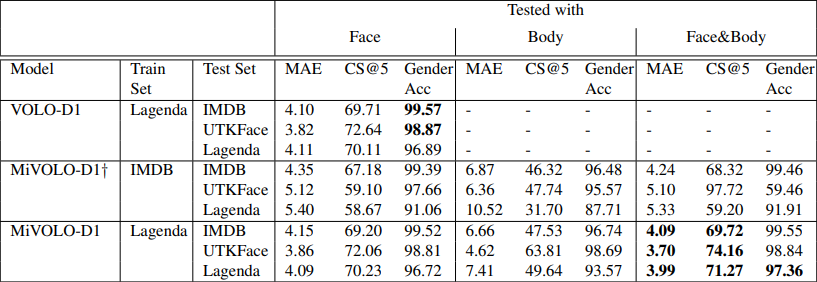

Веса модели, обученной на данном датасете, доступны по [ссылке](https://drive.google.com/file/d/1hKFmIR6fjHMevm-a9uPEAkDLrTAh-W4D/view). Воспользуемся ими для того, чтобы сделать инференс на датасет Adience.

In [10]:
%%bash

pwd

source MiVOLO/mivolo_env/bin/activate 

python3 MiVOLO/eval_pretrained.py \
  --dataset_images adience/faces \
  --dataset_annotations adience/annotations/ \
  --dataset_name adience \
  --batch-size 256 \
  --checkpoint MiVOLO/models/model_utkface.pth.tar \
  --split adience \
  --half \
  --with-persons \
  --device "cuda:0"

/mnt/c/Users/Alex/Desktop/fkii_cw


/mnt/c/Users/Alex/Desktop/fkii_cw/MiVOLO/mivolo/model/mi_volo.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")
Model me

Reading adience/annotations/adience_annotations.csv (type: AnnotType.PERSONS)...


Check annotations... 0 images skipped (0 crops are incorrect); 0 images corrupted: 100%|██████████| 18662/18662 [00:38<00:00, 478.74it/s] 
Dataset length: 18662 crops
Received predefined min_age 1 and max_age 95



Left images: 18662


Test: [   0/73]  Time: 15.789s (15.789s,   16.21/s)  Loss:  0.0000 (0.0000)  Gender Acc:   92.78 (  92.78) Age Acc:   28.12 (  28.12)
Test: [  10/73]  Time: 11.457s (11.583s,   22.10/s)  Loss:  0.0000 (0.0000)  Gender Acc:   73.86 (  94.60) Age Acc:   28.52 (  39.61)
Test: [  20/73]  Time: 10.581s (11.334s,   22.59/s)  Loss:  0.0000 (0.0000)  Gender Acc:   91.02 (  91.93) Age Acc:   42.19 (  42.72)
Test: [  30/73]  Time: 11.375s (11.270s,   22.72/s)  Loss:  0.0000 (0.0000)  Gender Acc:   78.74 (  92.93) Age Acc:   27.34 (  47.36)
Test: [  40/73]  Time: 10.730s (11.234s,   22.79/s)  Loss:  0.0000 (0.0000)  Gender Acc:   96.09 (  90.08) Age Acc:   62.50 (  45.80)
Test: [  50/73]  Time: 11.449s (11.238s,   22.78/s)  Loss:  0.0000 (0.0000)  Gender Acc:   97.66 (  89.38) Age Acc:   71.09 (  44.52)
Test: [  60/73]  Time: 11.460s (11.224s,   22.81/s)  Loss:  0.0000 (0.0000)  Gender Acc:   83.40 (  89.23) Age Acc:   53.01 (  47.16)
Test: [  70/73]  Time: 11.394s (11.216s,   22.82/s)  Loss:  0.

--result
{
    "model": "MiVOLO/models/model_utkface.pth.tar",
    "dataset_name": "adience",
    "param_count": 27.43,
    "img_size": 224,
    "use_faces": true,
    "use_persons": true,
    "in_chans": 6,
    "batch": 256,
    "mean_inference_time": 44.36666997934689,
    "mean_preprocessing_time": 0.6661066709000663,
    "agetop1": 48.4373,
    "agetop1_err": 51.5627,
    "gendertop1": 89.2065,
    "gendertop1_err": 10.7935
}


In [11]:
IMAGE_FOLDER_PATH = 'utk-face_cropped'
IMAGE_SIZE = (64, 64)
THRESHOLD = 3

Кластеризация данных UTKFace позволяет выявить скрытые структуры в датасете, такие как возрастные группы, распределение по полу или этническим группам.

Для поиска выбросов (outliers) воспользуемся статистической мерой Z-score, которая позволяет привести все значения признаков (например, интенсивности пикселей) к стандартной шкале с нулевым средним и единичным стандартным отклонением.

In [12]:
from scipy.stats import zscore

file_list = os.listdir(IMAGE_FOLDER_PATH)
data = []
images = []

for file_name in file_list:
    img_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    img = Image.open(img_path).resize(IMAGE_SIZE).convert('L')
    img_array = np.array(img).flatten()
    data.append(img_array)
    images.append(img)

data = np.array(data)

mean_pixel_values = np.mean(data, axis=1)
z_scores = zscore(mean_pixel_values)

outliers_idx = np.where(np.abs(z_scores) > THRESHOLD)[0]
print(f"Количество выбросов: {len(outliers_idx)}")
outliers_idx

outlier_filenames = [file_list[i] for i in outliers_idx]

Количество выбросов: 17


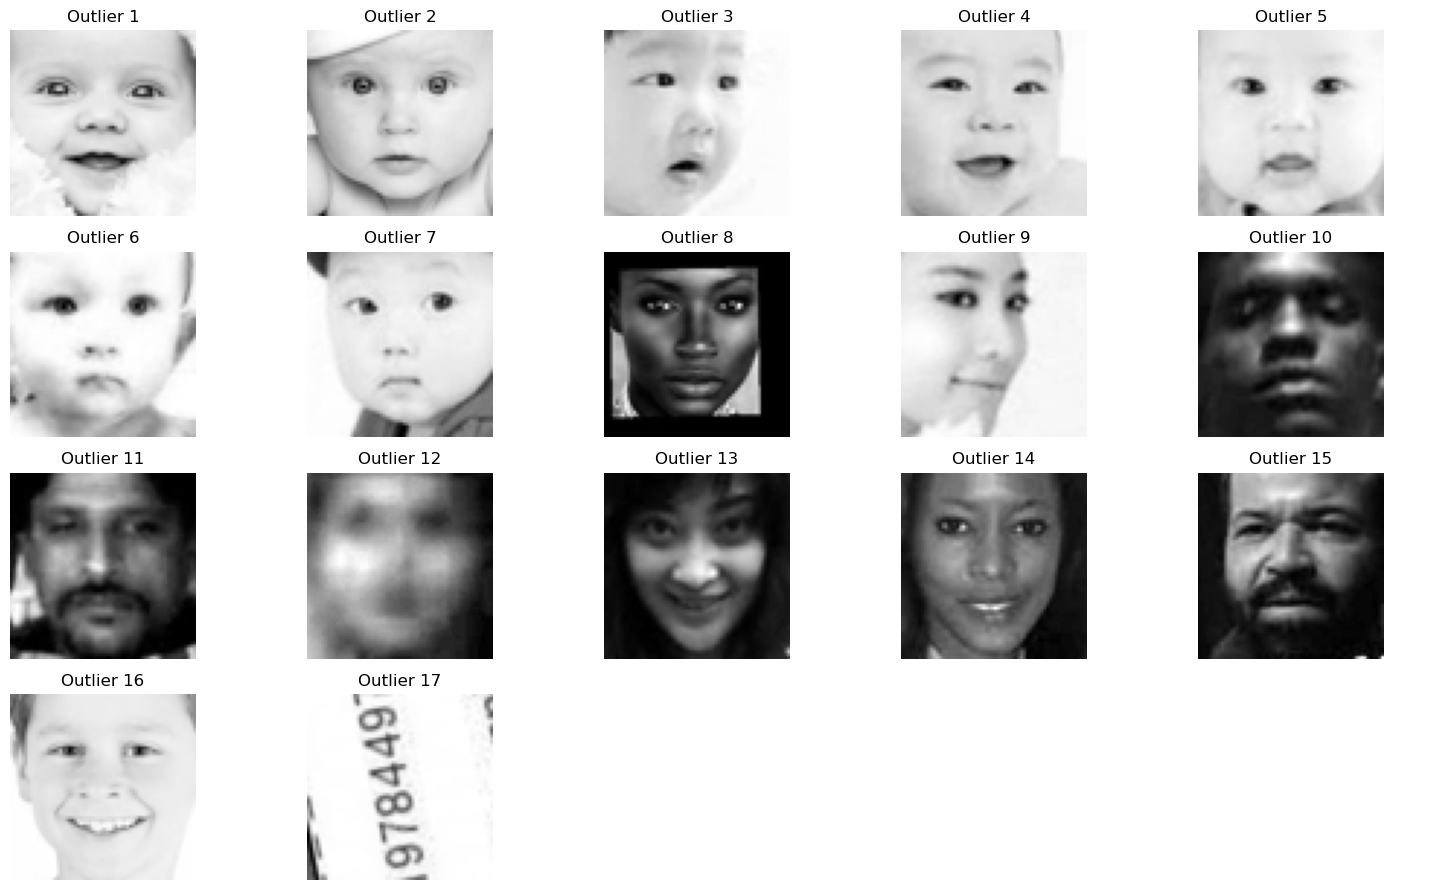

In [13]:
def visualize_outliers(images, outliers_idx, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(outliers_idx):
            img = images[outliers_idx[i]]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"Outlier {i+1}")
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_outliers(images, outliers_idx, rows=4, cols=5)

Подгрузим данные и выполним предварительную подготовку перед кластеризацией. Важно учесть, что датасет содержит фотографии с "неизвестной" рассой. Данные фотографии могут повлиять на качество кластеризации, поэтому необходимо не исключить их.

In [14]:
def load_images(image_folder_path, image_size):
    images = []
    labels = []
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    for filename in os.listdir(image_folder_path):
        if filename.endswith('.jpg'):
            label = filename.split('_')
            if len(label) < 4:
                continue
            if filename not in outlier_filenames:
                race = int(label[2])
                img_path = os.path.join(image_folder_path, filename)
                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img)
                images.append(img_tensor)
                labels.append(race)
    return torch.stack(images), torch.tensor(labels)  

images, labels = load_images(IMAGE_FOLDER_PATH, IMAGE_SIZE)
print(f"Images: {images.shape}")

Images: torch.Size([23688, 3, 64, 64])


Для визуализации или кластеризации можно использовать методы снижения размерности. Воспользуемся методом PCA (Principal Component Analysis), который преобразует высокоразмерные данные в пространство с меньшим количеством признаков, сохраняя основную информацию.

Оптимальне число главных компонет будем выбирать согласно методу объяснённой дисперсии. Данный метод заключается в выборе числа компонент так, чтобы доля объясненной дисперсии достигла заданного порога (например, 95% или 99%)

Number of Principal Components: 12288
Number of components explaining 95% variance: 181


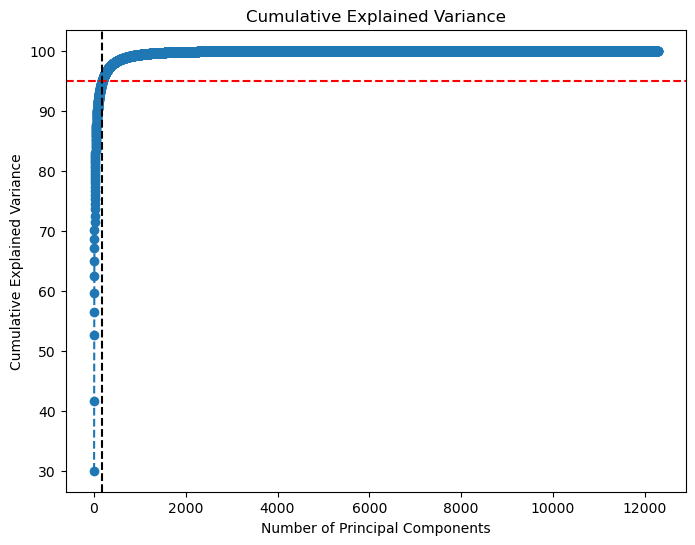

In [15]:
images_flat = images.view(images.size(0), -1).numpy()
scaler = StandardScaler()
images_scaled = scaler.fit_transform(images_flat)

pca = PCA()
pca.fit(images_scaled)
var_cumu = np.cumsum(pca.explained_variance_ratio_) * 100
print(f"Number of Principal Components: {len(var_cumu)}")

k = np.argmax(var_cumu > 95)
print(f"Number of components explaining 95% variance: {k}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), var_cumu, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=95, color='r', linestyle='--')
plt.axvline(x=k, color="k", linestyle="--")
plt.show()

Кластеризацию будем производить с использованием метода [K-means](https://education.yandex.ru/handbook/ml/article/klasterizaciya). Он используется для разделения данных на $k$
кластеров, где каждый кластер формируется вокруг своего центроида. Алгоритм итеративно находит оптимальное разбиение данных, минимизируя внутрикластерное расстояние (по умолчанию - евклидово расстояние).

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


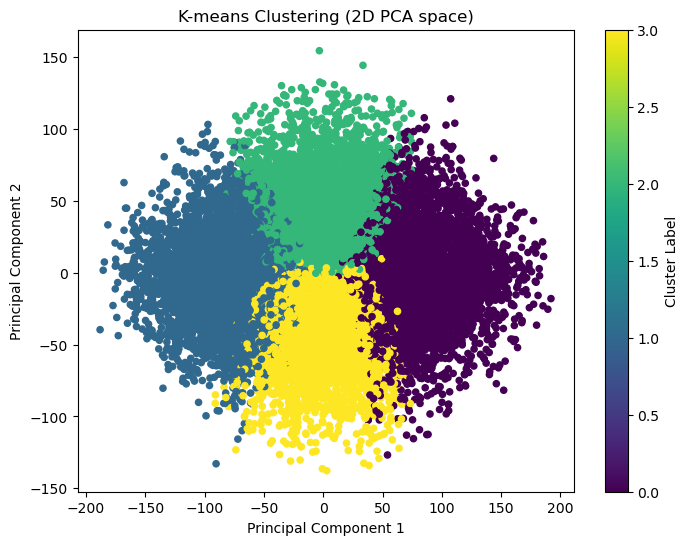

In [16]:
pca = PCA(n_components=k)
images_pca = pca.fit_transform(images_scaled)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(images_pca)

plt.figure(figsize=(8, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=kmeans_labels, cmap='viridis', s=20)
plt.title('K-means Clustering (2D PCA space)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

(для n_components = 2)

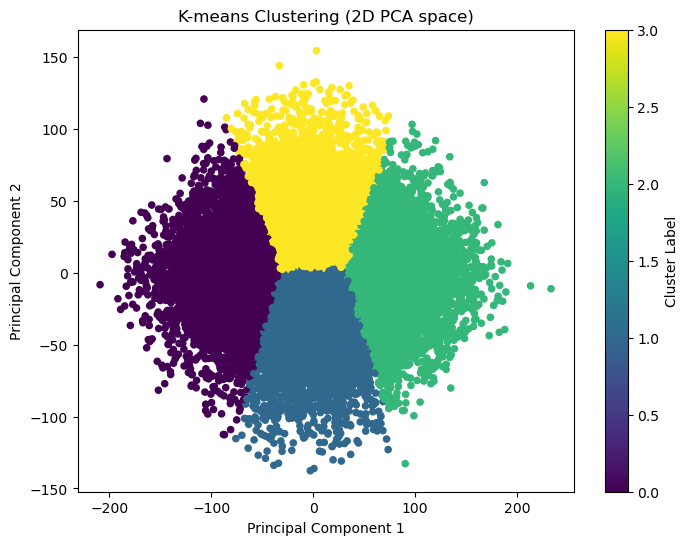

Метрики кластеризации:

Silhouette Score измеряет, насколько хорошо каждая точка вписывается в свой кластер, сравнивая внутрикластерное расстояние и расстояние до ближайшего соседнего кластера

In [17]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(images_pca, kmeans_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.1138


Davies-Bouldin Index измеряет среднюю схожесть между кластерами, где схожесть определяется как отношение расстояния между центроидами к радиусу кластеров.

In [18]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin = davies_bouldin_score(images_pca, kmeans_labels)
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

Davies-Bouldin Index: 2.2346


Calinski-Harabasz Index оценивает соотношение между дисперсией между кластерами и внутри кластеров.

In [19]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz = calinski_harabasz_score(images_pca, kmeans_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

Calinski-Harabasz Index: 3601.6992


Выполним визуализацию алгоритма кластеризации с использованием [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html), который является инструментом  для визуализации и мониторинга экспериментов машинного обучения.

In [20]:
%%bash

pwd

if [ -d "logs/pytorch_projector_clusters" ]; then
    rm -r logs/pytorch_projector_clusters
fi

/mnt/c/Users/Alex/Desktop/fkii_cw


Визуализируем результат кластеризации для 10000 случайных фотографий.

In [21]:
NUM_IMAGES = 10000

cluster_labels = [f"Cluster {label}" for label in kmeans_labels]

log_dir = "logs/pytorch_projector_clusters"
writer = SummaryWriter(log_dir)

def select_n_random(data, labels, n):
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)
images = unnormalize(images)

selected_images, selected_labels = select_n_random(images, torch.tensor(kmeans_labels), n=NUM_IMAGES)
print(f"Selected images shape: {selected_images.shape}")

features = selected_images.view(selected_images.size(0), -1)
cluster_names = [f"Cluster {label.item()}" for label in selected_labels]

writer.add_embedding(
    features,                    
    metadata=cluster_names,      
    label_img=selected_images
)

writer.close()

log_images_to_tensorboard = lambda images, labels, step: None
log_images_to_tensorboard(images, kmeans_labels, 0)

Selected images shape: torch.Size([10000, 3, 64, 64])


In [48]:
%%bash

pwd

if lsof -i :6006; then
    lsof -t -i :6006 | xargs kill -9
fi

/mnt/c/Users/Alex/Desktop/fkii_cw


In [ ]:
%reload_ext tensorboard 
%tensorboard --logdir logs/pytorch_projector_clusters --samples_per_plugin=images=10000 --port 6004
# %tensorboard --logdir logs

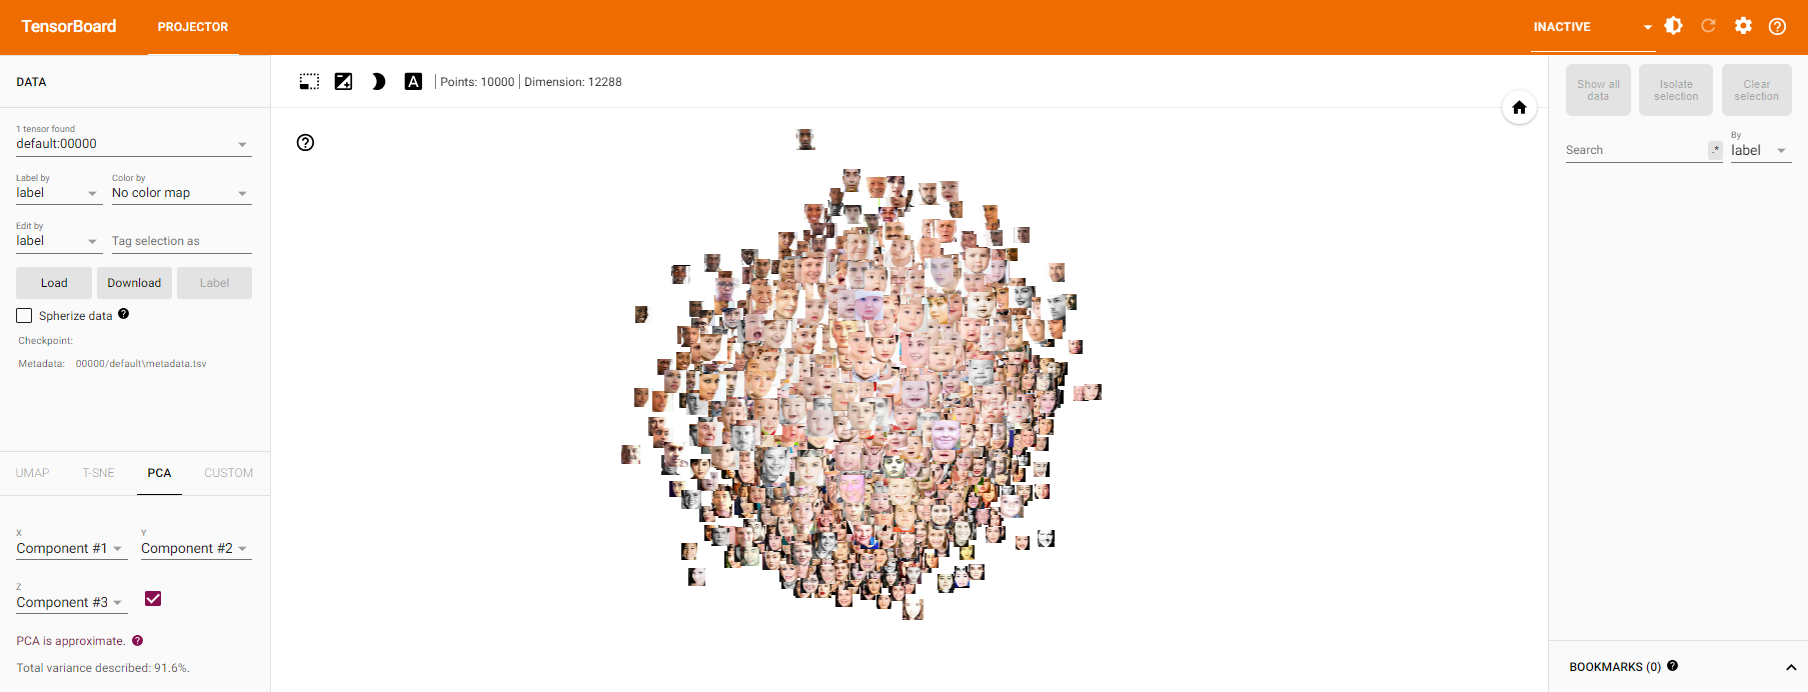

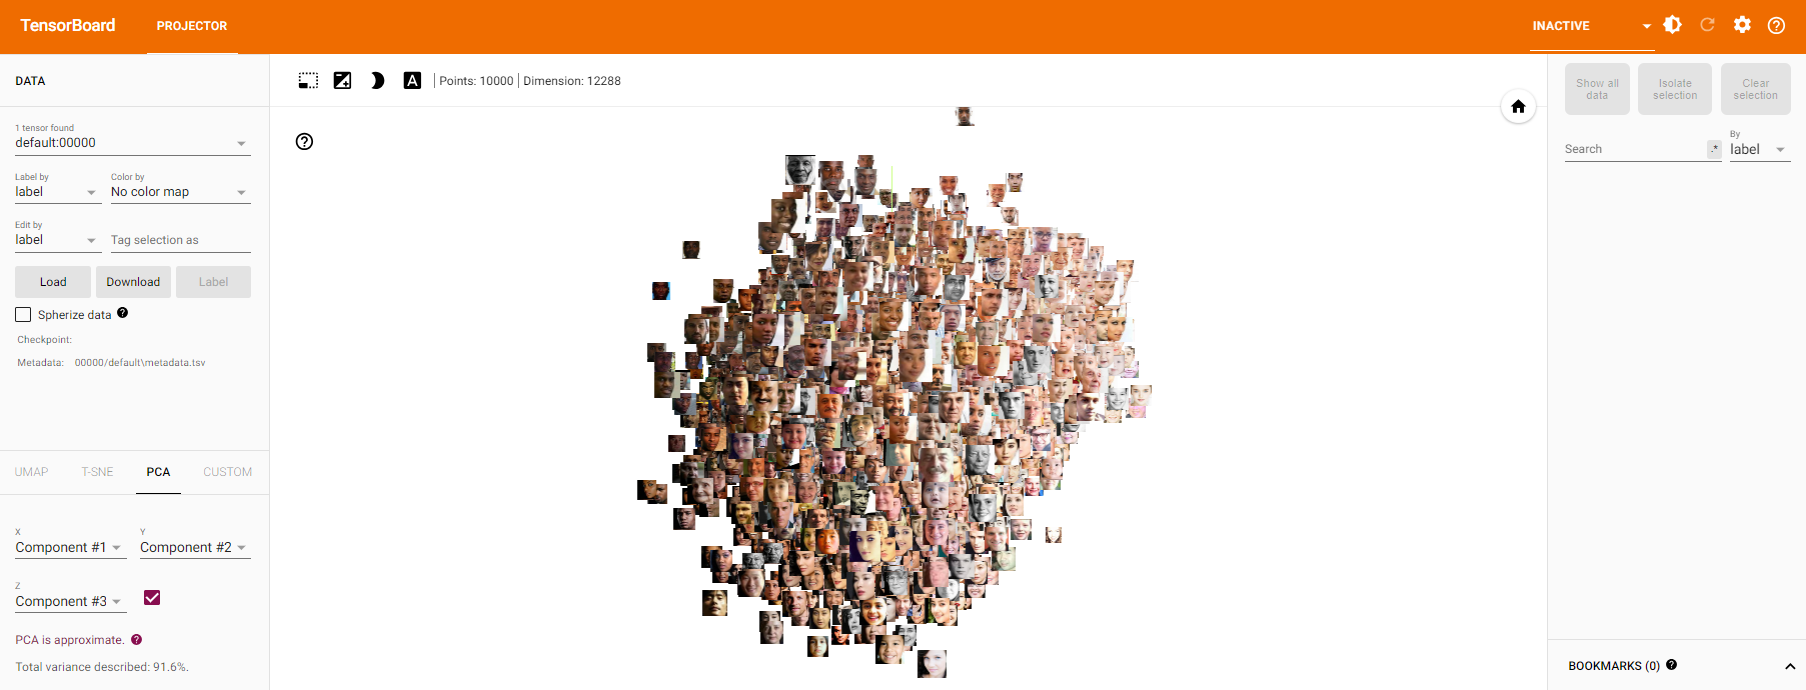

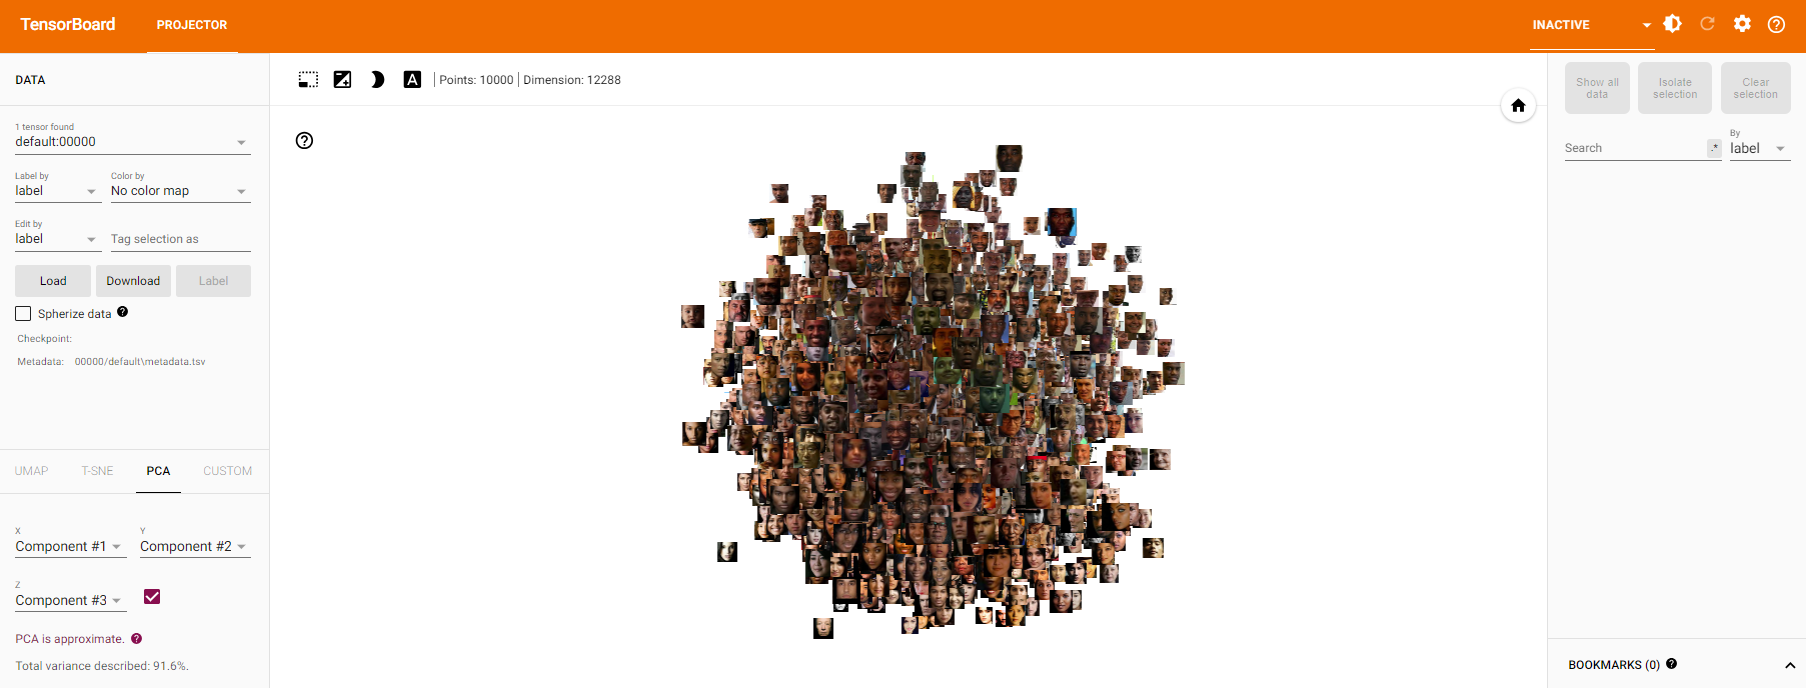

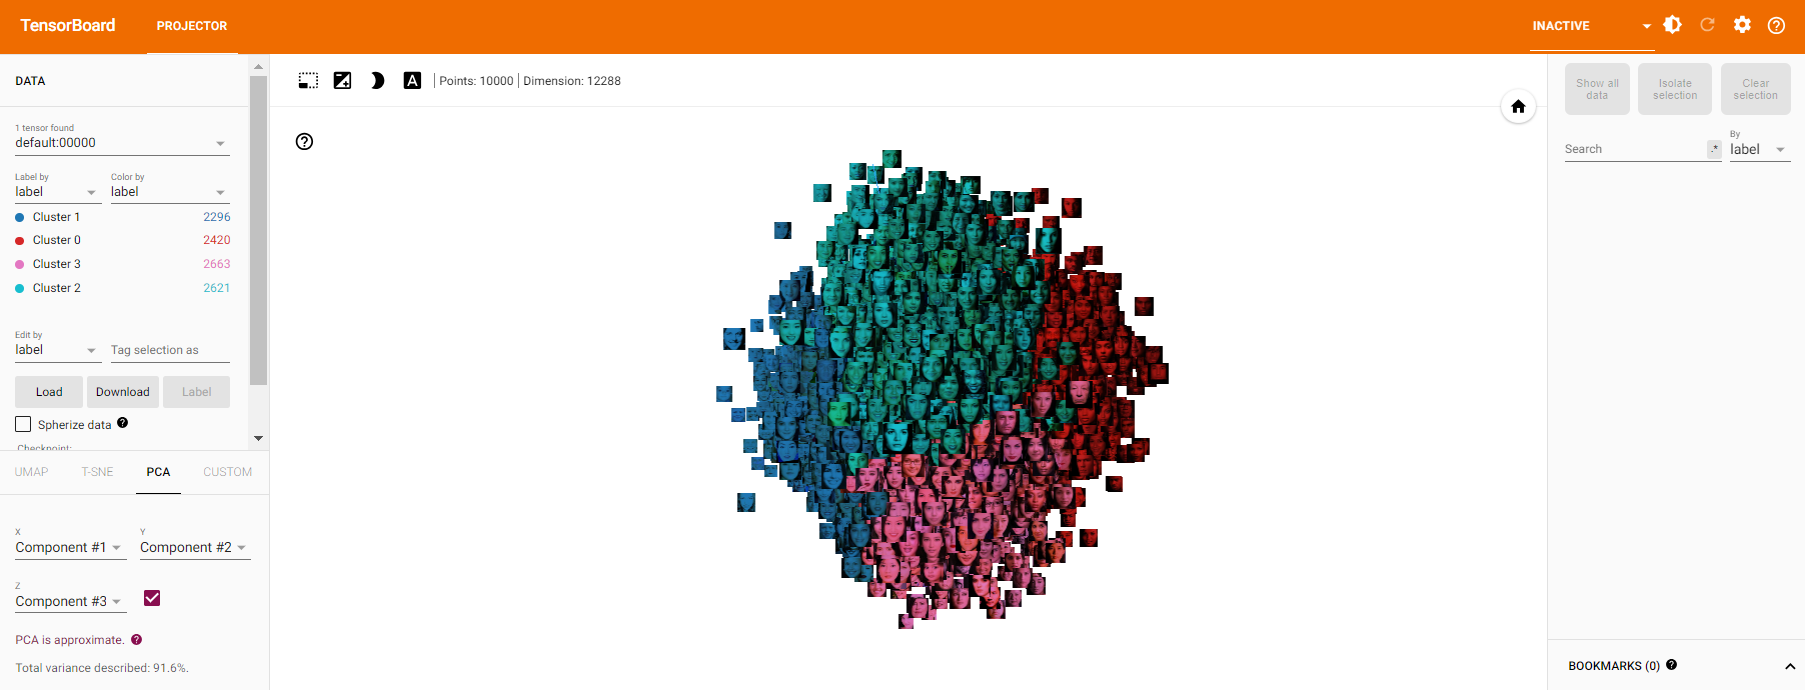

ML System Design с использованием датасета UTKFace включает разработку и внедрение моделей машинного обучения для классификации возраста, пола и этнической принадлежности по изображениям лиц.

ПРИМЕР №1   

В данном [проекте](https://github.com/MoritzM00/AgePrediction-UTKFace?utm_source=chatgpt.com) решается задача оценки возраста по изображениям лиц с использованием глубоких сверточных нейронных сетей (Deep CNN).

- обучение CNN осуществляется с примененением двух датасетов: UTKFace и B3F-Dataset (B3FD);
- используемые оптимизаторы: Adam и AdamW;
- тестируемые архитектуры: EfficientNetV2, Baseline CNN.

Реальные кейсы применения:
- Демографический анализ;
- Медицинские приложения;
- Системы безопасности.


ПРИМЕР №2

В статье [Facial Expression and Attributes Recognition Based on Multi-Task Learning of Lightweight Neural Networks](https://www.semanticscholar.org/reader/54c1cab085e6f786a413a1aee9dde5ca17423e43) автор Андрей Савченко исследует применение многозадачного обучения легковесных сверточных нейронных сетей для распознавания лиц и классификации их атрибутов, таких как возраст, пол и этническая принадлежность.

- используемые датасеты: UTKFace, AffectNet, AFEW и VGAF;
- используемые оптимизаторы: Adam и AdamW, SGD;
- используемые нейронные сети: MobileNet, EfficientNet, RexNet;

Реальные кейсы применения:

- Мобильные приложения;
- Системы видеонаблюдения;
- Медицинские приложения.